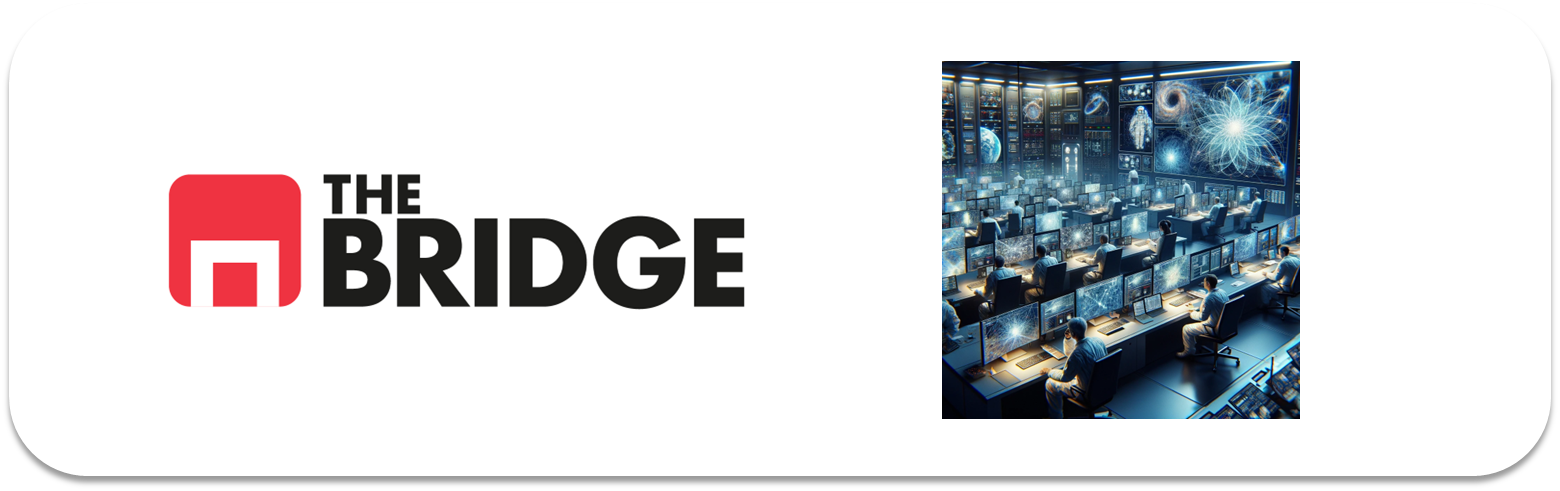

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import os
import cv2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imageio import imread  # Alternativamente, usar matplotlib.pyplot.imread

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPool2D
from keras.layers import Flatten, Dense

from keras.optimizers import Adam

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from time import time

from tensorflow.keras.applications.vgg16 import VGG16

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



#### CARGAMOS LOS DATOS

In [2]:
root_path = './data/'

train_path = root_path + "seg_train/"

test_path = root_path + "seg_test/"

In [3]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
# Dividimos en X_train, y_train y X_test, y_test

X_train, y_train = read_data(train_path)

print(f"Datos cargados: X_train={X_train.shape}, y_train={y_train.shape}")

Datos cargados: X_train=(14034, 32, 32, 3), y_train=(14034,)


In [5]:
X_test, y_test = read_data(test_path)

print(f"Datos cargados: X_test={X_test.shape}, y_test={y_test.shape}")

Datos cargados: X_test=(3000, 32, 32, 3), y_test=(3000,)


#### VISUALIZAMOS LOS DATOS

In [6]:
def show_images_batch(images, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(images) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, pet in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(pet, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

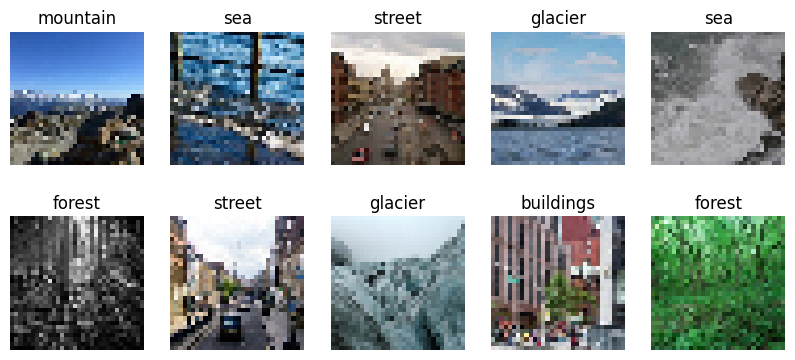

In [7]:
indices = np.random.randint(0,14034,10)

show_images_batch(X_train[indices], names = y_train[indices])

#### MINI-EDA

In [8]:
pd.Series(y_train).value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

*Tenemos un dataset bastante balanceado*

#### ESCALAMOS LAS IMÁGENES

In [9]:
# Comprobamos el valor máximo de los datos

X_train.max()

np.uint8(255)

In [10]:
X_train = X_train/255
X_test = X_test/255

In [11]:
X_train

array([[[[0.96862745, 0.96862745, 0.96078431],
         [0.96862745, 0.97647059, 0.96470588],
         [0.96862745, 0.97647059, 0.96470588],
         ...,
         [0.98039216, 0.98039216, 0.97254902],
         [0.98039216, 0.98039216, 0.98039216],
         [0.97254902, 0.97254902, 0.96862745]],

        [[0.96862745, 0.97647059, 0.96470588],
         [0.96862745, 0.97647059, 0.96470588],
         [0.96862745, 0.97647059, 0.96470588],
         ...,
         [0.98823529, 0.98823529, 0.98823529],
         [0.98431373, 0.98431373, 0.98431373],
         [0.98039216, 0.98039216, 0.97647059]],

        [[0.97254902, 0.98039216, 0.98039216],
         [0.96862745, 0.97647059, 0.97254902],
         [0.97254902, 0.98039216, 0.97647059],
         ...,
         [0.99215686, 0.99215686, 0.99215686],
         [0.98823529, 0.98823529, 0.98823529],
         [0.98823529, 0.98823529, 0.98823529]],

        ...,

        [[0.27843137, 0.2745098 , 0.26666667],
         [0.31764706, 0.31372549, 0.30588235]

#### SHUFFLE - PARA ALEATORIZAR LOS DATOS

In [12]:
X_train, y_train = shuffle(X_train, y_train, random_state = 42)

In [13]:
# Comprobamos la tipología de los datos de test

np.unique(y_train)

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

In [14]:
# Convertimos los valores de las etiquetas y_train e y_test a numéricos

mapping = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5}

y_train = np.vectorize(lambda x: mapping.get(x, -1))(y_train)  # Usa -1 para valores no mapeados
y_test = np.vectorize(lambda x: mapping.get(x, -1))(y_test)  # Usa -1 para valores no mapeados

#### MODELO BASE - AD-HOC

In [15]:
# De aquí sacamos el tipo de modelo que vamos a construir, que sigue siendo una secuencia o cadena de capas consecutivas

model = Sequential() # Creamos el modelo para ir añadiendo las capas

In [16]:
layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same",input_shape=(32,32,3)), # Padding "Valid" (sin padding), "Same" (ajusta para que entre todo), Integer -> el relleno que yo quiera. 
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 2x2 -> A dividir por 2 la resolución de cada dimensión de la capa anterior, 32x32 -> 16x16 
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 16x16 -> 8x8
    keras.layers.Dropout(rate = 0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), # 1024 -> 32*32
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(6, activation='softmax') # -> loss = "sparse_categorical_crossentropy" (categorical_crossentropy es cuando y_train = [0,1] o y_train = [0,0,1,0,0]
    # keras.layers.Dense(1, activation='sigmoid') # -> loss = "binary_crossentropy"
]

model = keras.Sequential(layers)

In [17]:
X_train.size

43112448

*Nos vale un Adam, podríamos probar un SGD*

In [18]:
optimizer = keras.optimizers.Adam()

In [19]:
metrics = ["accuracy"] # dataset equilibrado
loss = "sparse_categorical_crossentropy" # Es un clasificador de 6 clases

In [20]:
batch_size = 64

len(X_train)/batch_size

219.28125

*Cada época tendrá 219 pasadas por el algoritmo de entrenamiento, también llamados steps*

Escogemos un número alto de épocas y usamos un EarlyStopping con paciencia 10 para no tener que depender del número de épocas

In [21]:
num_epochs = 10

In [22]:
earlyS = keras.callbacks.EarlyStopping(patience = 10)

Compilamos y mostramos un resumen del modelo

In [23]:
model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,273,542 (16.30 MB)

 Trainable params: 4,273,542 (16.30 MB)

 Non-trainable params: 0 (0.00 B)

Hora de entrenar y mostrar ese entrenamiento, pero primero vamos a lanzar una sóla época para ver tiempos y antes convertir el target a numérico

In [25]:
y_train[np.array([1,2,3560])]

array([5, 5, 1])

Como vamos a tener que lanzar varios entrenamientos para poder simular un reseteo de pesos creamos una función que nos hace eso, nos devuelve el modelo preparado para un nuevo fit

In [26]:
def prepare_model(resolucion = (32,32)):

    layers = [
    keras.layers.Conv2D(64,(3,3), activation = 'relu', padding= "same",input_shape=(32,32,3)), # Padding "Valid" (sin padding), "Same" (ajusta para que entre todo), Integer -> el relleno que yo quiera. 
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 2x2 -> A dividir por 2 la resolución de cada dimensión de la capa anterior, 32x32 -> 16x16 
    keras.layers.Dropout(rate = 0.25),
    
    keras.layers.Conv2D(128,(3,3), activation = 'relu', padding= "same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), padding = "same"), # 16x16 -> 8x8
    keras.layers.Dropout(rate = 0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), # 1024 -> 32*32
    keras.layers.Dropout(rate = 0.5),
    keras.layers.Dense(6, activation='softmax') # -> loss = "sparse_categorical_crossentropy" (categorical_crossentropy es cuando y_train = [0,1] o y_train = [0,0,1,0,0]
    # keras.layers.Dense(1, activation='sigmoid') # -> loss = "binary_crossentropy"
    ]

    model = keras.Sequential(layers)
    optimizer = keras.optimizers.Adam()
    metrics = ["accuracy"] # dataset equilibrado
    loss = "sparse_categorical_crossentropy" # Es un clasificador de 6 clases

    model.compile(optimizer= optimizer,
              loss= loss,
              metrics= metrics)
    
    return model

In [27]:
model = prepare_model()
t_zero = time()

history = model.fit(X_train,
          y_train,
          epochs=1,
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)

dur_epoca = time()-t_zero

176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.4472 - loss: 1.4129 - val_accuracy: 0.6270 - val_loss: 0.9602


In [28]:
print(dur_epoca)

20.504428148269653


*20 segundos para cada época. Ojo con usar un número alto de épocas ya que consumiría mucho tiempo*

In [29]:
model = prepare_model()
t_zero = time()

history = model.fit(X_train,
          y_train,
          epochs= num_epochs,
          batch_size= batch_size,
          callbacks = [earlyS],
          validation_split=0.2)

dur_epoca = time()-t_zero

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.4772 - loss: 1.3136 - val_accuracy: 0.6990 - val_loss: 0.8314
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.6953 - loss: 0.8222 - val_accuracy: 0.7520 - val_loss: 0.6768
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.7480 - loss: 0.6931 - val_accuracy: 0.7781 - val_loss: 0.6185
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.7763 - loss: 0.6176 - val_accuracy: 0.7905 - val_loss: 0.5939
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.8018 - loss: 0.5472 - val_accuracy: 0.7859 - val_loss: 0.6139
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.8107 - loss: 0.5043 - val_accuracy: 0.7912 - val_loss: 0.5885
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.8401 - loss: 0.4481 - val_accuracy: 0.8019 - val_loss: 0.5684
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.8532 - loss: 0.4037

In [30]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8085 - loss: 0.5936


[0.6157552003860474, 0.8003333210945129]

Pintemos la evolución de los dos entrenamientos

In [31]:
df_evol = pd.DataFrame(history.history)

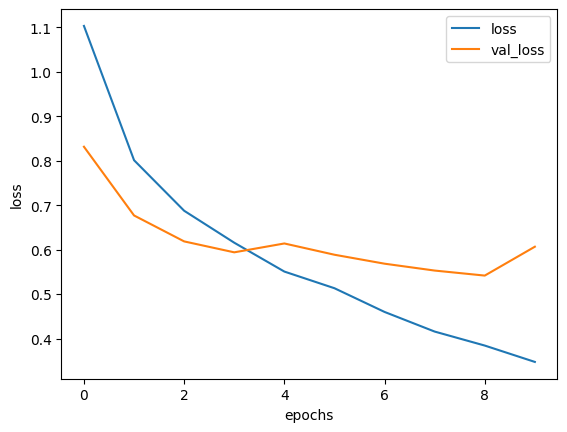

In [32]:
df_evol[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

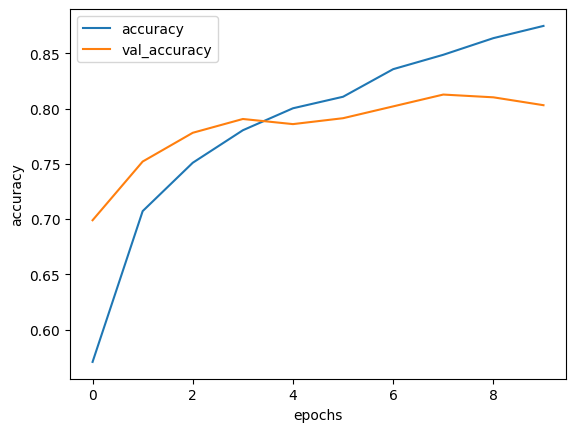

In [33]:
df_evol[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

*No siempre debemos parar en cuanto val y train se separan pero tampoco esperar mucho más*

In [34]:
model.evaluate(X_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8085 - loss: 0.5936


[0.6157552003860474, 0.8003333210945129]

In [35]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75       437
           1       0.94      0.92      0.93       474
           2       0.83      0.69      0.75       553
           3       0.77      0.77      0.77       525
           4       0.79      0.79      0.79       510
           5       0.79      0.84      0.81       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [37]:
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

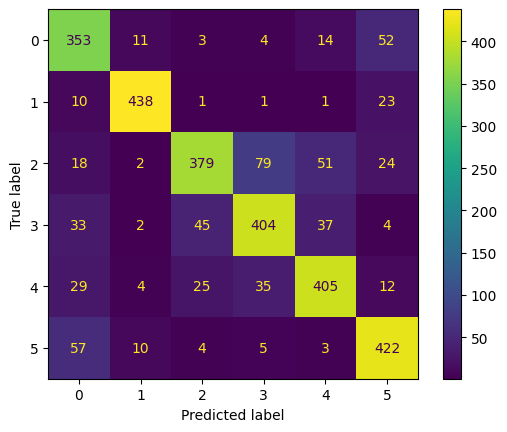

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#### MODELO PREENTRENADO Y AJUSTADO CON TRANSFER LEARNING

Vamos a utilizar la arquitectura correspondiente a **VGG**

In [39]:
# Cargamos el modelo

model_vgg_tl = VGG16(input_shape = (32, 32, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

Vamos a "congelar" las capas de la VGG, es decir no vamos a permitir que se entrenen

In [40]:
for layer in model_vgg_tl.layers:
    layer.trainable = False

In [41]:
##### FULLY CONNECTED LAYER #####

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(model_vgg_tl.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(6, activation='softmax')(x)

model_tl = tf.keras.models.Model(model_vgg_tl.input, x)

model_tl.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [42]:
model_tl.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Y ya ahora solo tenemos que entrenar:

In [43]:
t_zero_vgg_tl = time()

vgghist_tl = model_tl.fit(X_train,
                    y_train,
                    epochs= num_epochs,
                    batch_size = batch_size,
                    callbacks = [earlyS],
                    validation_split=0.2)

dur_epoca_vgg_tl = time()-t_zero_vgg_tl

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 354ms/step - acc: 0.5389 - loss: 1.1661 - val_acc: 0.7200 - val_loss: 0.7587
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 310ms/step - acc: 0.7122 - loss: 0.7615 - val_acc: 0.7374 - val_loss: 0.7156
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 325ms/step - acc: 0.7420 - loss: 0.7060 - val_acc: 0.7453 - val_loss: 0.6844
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 300ms/step - acc: 0.7447 - loss: 0.6863 - val_acc: 0.7471 - val_loss: 0.6775
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 289ms/step - acc: 0.7573 - loss: 0.6541 - val_acc: 0.7453 - val_loss: 0.6710
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 290ms/step - acc: 0.7654 - loss: 0.6347 - val_acc: 0.7535 - val_loss: 0.6625
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 288ms/step - acc: 0.7725 - loss: 0.6027 - val_acc: 0.7585 - val_loss: 0.6513
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 51s 289ms/step - acc: 0.7823 - loss: 0.5997 - val_acc: 0.7563 - val_loss: 0.6508
Epoch 9/10
176/176 ━━━━━━━━━━━━━

In [44]:
dur_epoca_vgg_tl

606.4135510921478

In [45]:
df_vgg_tl = pd.DataFrame(vgghist_tl.history)

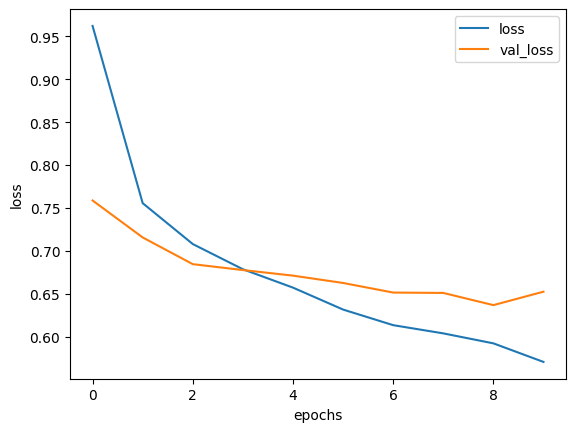

In [46]:
df_vgg_tl[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

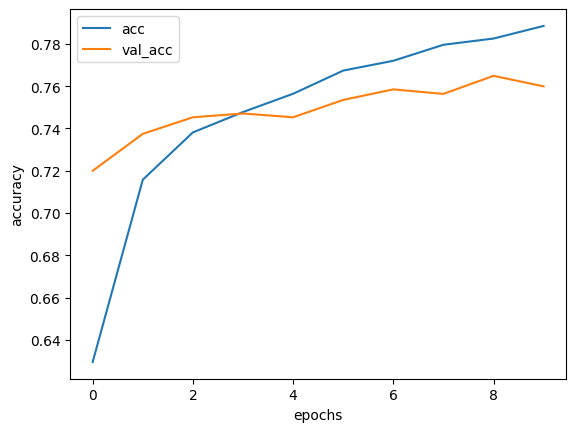

In [47]:
df_vgg_tl[["acc","val_acc"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

Y tendríamos nuestro modelo sobre la VGG, vamos a evaluarlo:

In [48]:
model_tl.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - acc: 0.7596 - loss: 0.6391


[0.6567376852035522, 0.7563333511352539]

In [49]:
y_pred_vgg_tl = [np.argmax(prediction) for prediction in  model_tl.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step


In [50]:
print(classification_report(y_test,y_pred_vgg_tl))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       437
           1       0.90      0.91      0.91       474
           2       0.63      0.80      0.70       553
           3       0.77      0.63      0.69       525
           4       0.79      0.68      0.73       510
           5       0.76      0.82      0.79       501

    accuracy                           0.76      3000
   macro avg       0.77      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



In [51]:
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

#### MODELO PREENTRENADO Y AJUSTADO CON FINE-TUNING

No cargamos pesos en la red, solo la topología. Y tampoco nos quedamos con las cabezas superiores

In [52]:
model_vgg_ft = VGG16(input_shape = (32, 32, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = None,
                    classifier_activation="softmax")

In [53]:
##### FULLY CONNECTED LAYER #####

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(model_vgg_ft.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(6, activation='softmax')(x)

model_ft = tf.keras.models.Model(model_vgg_ft.input, x)

model_ft.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [54]:
model_ft.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 14,980,422 (57.15 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
t_zero_vgg_ft = time()

vgghist_ft = model_ft.fit(X_train,
                    y_train,
                    epochs= num_epochs,
                    batch_size = batch_size,
                    callbacks = [earlyS],
                    validation_split=0.2)

dur_epoca_vgg_ft = time()-t_zero_vgg_ft

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - acc: 0.1727 - loss: 1.7949 - val_acc: 0.1831 - val_loss: 1.7910
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - acc: 0.1780 - loss: 1.7910 - val_acc: 0.1831 - val_loss: 1.7908
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - acc: 0.1804 - loss: 1.7912 - val_acc: 0.1689 - val_loss: 1.7911
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - acc: 0.1786 - loss: 1.7916 - val_acc: 0.1831 - val_loss: 1.7906
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - acc: 0.1693 - loss: 1.7911 - val_acc: 0.1831 - val_loss: 1.7906
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - acc: 0.1770 - loss: 1.7908 - val_acc: 0.1831 - val_loss: 1.7905
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - acc: 0.1769 - loss: 1.7911 - val_acc: 0.1831 - val_loss: 1.7907
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - acc: 0.1799 - loss: 1.7907 - val_acc: 0.1831 - val_loss: 1.7907
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/

In [56]:
dur_epoca_vgg_ft

2193.0464429855347

In [57]:
df_vgg_ft = pd.DataFrame(vgghist_ft.history)

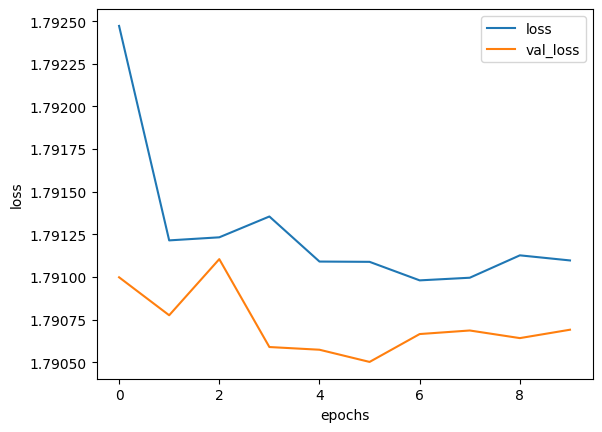

In [58]:
df_vgg_ft[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

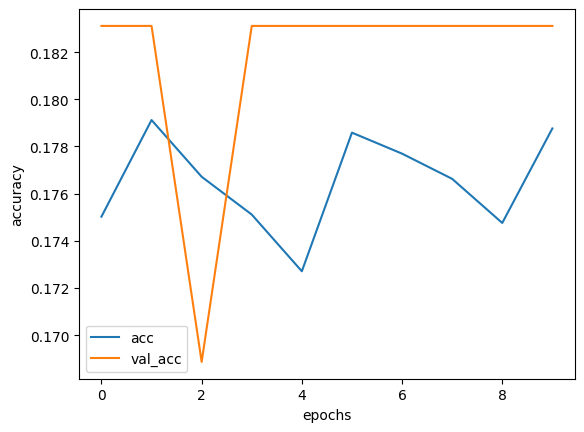

In [59]:
df_vgg_ft[["acc","val_acc"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [60]:
model_ft.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - acc: 0.0993 - loss: 1.8110


[1.790286898612976, 0.17499999701976776]

In [61]:
y_pred_vgg_ft = [np.argmax(prediction) for prediction in  model_ft.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step


In [62]:
print(classification_report(y_test,y_pred_vgg_ft))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       437
           1       0.00      0.00      0.00       474
           2       0.00      0.00      0.00       553
           3       0.17      1.00      0.30       525
           4       0.00      0.00      0.00       510
           5       0.00      0.00      0.00       501

    accuracy                           0.17      3000
   macro avg       0.03      0.17      0.05      3000
weighted avg       0.03      0.17      0.05      3000



In [63]:
mapping

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}